In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# 画像読み込み
files = [    'iso050_timescale10000.DNG.npz',
               'iso050_timescale20000.DNG.npz',
               'iso050_timescale40000.DNG.npz',
               'iso050_timescale80000.DNG.npz',
               'iso050_timescale160000.DNG.npz',
               'iso050_timescale320000.DNG.npz',
               'iso050_timescale640000.DNG.npz',
               'iso050_timescale1280000.DNG.npz' ]

images = []; t = [] # 画像、露出時間
for i, file in enumerate( files ):
    t.append( 1/(10*2**i) ) # 露出時間を設定
    rgb = np.load(file)
    # npでシリアライズ保存したデータを読む
    images.append( np.stack( [rgb[ 'r'], rgb['g'], rgb['b'] ], axis=2 ) )

# 画像サイズ設定
height = len( images[0] )
width  = len( images[0][0] )

In [7]:
# 対象の輝度値×露出時間 - ”各撮影条件ごとの”オフセット値”＝撮影値というモデル
# で、”各撮影条件ごとの”オフセット値”を最適化してみる
from scipy import optimize
from scipy.optimize import fmin, fmin_bfgs, fmin_powell, minimize
import math

# 入力定数 YandTss 
# = [ [[撮影画素値, オフセット値] ....]画素位置数, ...  ]撮影条件数
# を受け取り、1個めの撮影条件基準で、2個目の撮影条件のオフセットを算出する
# 隣り合う撮影条件同士でオフセットを算出していく
def myError( X, YandTss ): 
    Tc = X  # 最適化したい、”各撮影条件ごとの”オフセット値”配列
    e = 0.0 # 誤差
    for pos in range( len(YandTss) ):                       # 画素位置数
        rads = []
        for i, YandTs in enumerate( YandTss[pos] ):  # 露光条件数
            Y = YandTs[0] # 撮影画素値
            T = YandTs[1] # 露光時間(s)
            # （0-2^14=16384の値域の）画素値上下端は使わない
            if ( 2500 < Y and Y < 15000 ):   # 中央領域なら
                if ( i==0 ):  # 最初の撮影条件基準とする（オフセット値＝0）
                    rads.append( Y / T - 0 )  # 輝度値
                else:                                   # オフセットを引いた輝度値
                    rads.append( Y/ T-Tc[0]  )
        if ( len(rads)==2 ): # 撮影条件を2個読み終んだら誤差（差分）を計算
            e = e + math.sqrt( (rads[1]-rads[0])**2 )
    return e

# オフセット値を推定（最適化）するための関数
def calcOffset(images, start, channel):
    # height = len( images[0] )
    # width  = len( images[0][0] )
    YandTss = []  #  = [ [[撮影画素値, 露光係数] ....]n, ...  ]pos
    for y in range( 10, height, 20 ):     # XY位置の画素を適当にサンプリング
        for x in range( 10, width, 20 ):
            YandTs = []
            for i in [start, start+1]:
                # 画素値, 露出時間  のペアーを配列に格納しておく
                YandTs.append(  [ images[i][y, x, channel], t[i] ] )
            YandTss.append( YandTs ) # [画素値, 露出時間  のペアー群]を並べたリスト
    
    # 定義済みのmyErrorを最小化する
    arg = (YandTss, )
    return  minimize( myError, 
        [0], args=arg      # 入力として与える定数
       ,method="nelder-mead"
       ,options={'xtol': 1e-4, 'ftol': 1e-4,
                       'maxiter': 1000, 'maxfev': 1000 })

(0, 12000000)

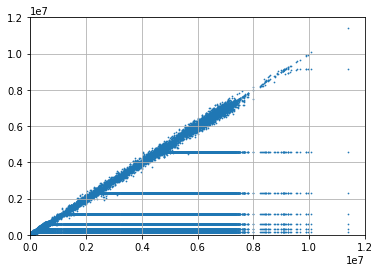

In [50]:
preOffset = 0 # 一個前までのオフセット値（積算）
offsets = [0]  # 各条件のオフセット、最初はゼロ
# （最初の条件以外の）各撮影条件の"オフセット値"算出
for i in range(len(images)-1):
    result = calcOffset( images, i, 1 )  # r=0, g=1, b=2
    preOffset = preOffset + result.x[0] 
    offsets.append( preOffset )

# 各条件毎から推定した輝度値を、8枚目基準で
# 並べてみる 
# (横軸＝8枚目で推定した輝度値、
# 縦軸各画像から推定した輝度値)
x0 = []; y0 = []  
for y in range( 0, height, 5 ):
    for x in range( 0, width, 5 ):
        for i in range( len(t) ):
            val0 = images[7][ y, x, 1 ] # 
            x0.append(  val0 / t[7]-offsets[7]   ) # 8枚目推定の輝度値
            val   = images[i][ y, x, 1 ]
            y0.append(  val / t[i]-offsets[i]   )     # 各条件推定の輝度値
            
plt.scatter(x0, y0, s=0.5) # 散布図を描いてみる
plt.grid()
plt.xlim([0,12000000])
plt.ylim([0,12000000])

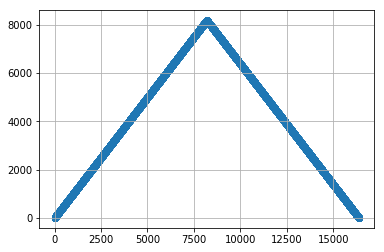

In [48]:
x = np.arange( pow(2,14) ) # 14bit分の画素値軸を作成
w = np.empty( pow(2,14) ) # 14bit分の画素値に対する重みを作成

for i in range( pow(2,14) ): # 中央が一番重みが高い三角形状
    w[i] = pow(2,14)/2 - abs(i-pow(2,14)/2)

plt.grid()
plt.scatter(x, w)

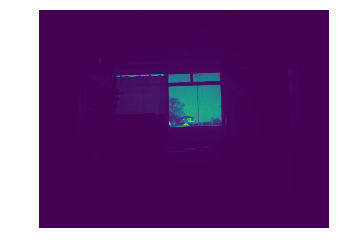

In [10]:
npimg = np.zeros((height, width))  # 生成画像
for y in range( height ):
    for x in range( width ):
        wsum = 0   # 重み付け平均をする際の「重み付け和」
        val = 0.0     # その画素位置に対する画素値
        for i in range( len( t ) ): # 露出条件数（撮影画像枚数）分
            v = images[i][ y, x, 1] # 緑=1チャンネルで処理をしてみる
            aw = w[ int(v) ]          # その撮影画像・画素値に対する重み
            wsum = wsum + aw
            # （輝度値ーオフセット値）×露出時間＝撮影値というモデル
            val = val + aw * (v / t[i] - os[i] )  
        # その画素に対する重み付け平均値を算出
        npimg[y, x] = val / wsum

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.axis("off")
plt.imshow(npimg)

In [29]:
import numpngw  # https://pypi.org/project/numpngw/#files
zgray = ( 65535 * ( ( npimg - npimg.min() ) / (npimg.max()-npimg.min() ) ) ).astype( np.uint16 )
numpngw.write_png('test.png', zgray)

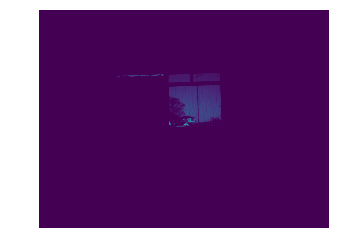

In [44]:
 plt.axis("off")
zgray =  ( npimg - npimg.min() ) / (npimg.max()-npimg.min() )
plt.imshow(
    np.apply_along_axis(lambda x: pow(x, 3.0), 1, zgray)
)  

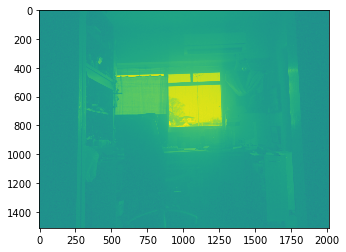

In [45]:
zgray =  ( npimg - npimg.min() ) / (npimg.max()-npimg.min() )
plt.imshow(
    np.apply_along_axis(lambda x: pow(x, 0.1), 1, zgray)
)  